## Feature Ideas

- User level features (row per user, timestamp):
    - `userId`
    - `timestamp`
    - `months_since_account_creation`
    - `display_name_is_null` (careful this isn't a leak!)
    - `website_url_is_null`
    - `about_me_length`
    - `location_is_null`
    - `num_badges`
    - `weeks_since_last_badge`
    - `badge_score`: sum of log(1 / badge_incidence) -- captures a total of badges weighted by their rarity. Eg: let's say a user has two badges, one that 5% of users have and another that 1% of users have, then the badge_score is log(20) + log(100)

- Post level features (row per user, timestamp, postid for posts created before timestamp) - for later aggregation:
    - `userId`
    - `timestamp`
    - `postId`
    - `post_type`
    - `post_rank`: to sort posts by age
    - `has_accepted_ans`: questions only
    - `is_accepted_ans`: answers only
    - `num_tags`: questions only
    - `title_length`: questions only
    - `body_length`
    - `days_since_last_post`
    - `num_postive_votes`
    - `num_negative_votes`
    - `num_comments`
    - `avg_comment_length`
    - `num_distinct_commenters`
    - `avg_commenter_badge_score`


- **Proposed feature set** (row per user, timestamp):
    - `* from user_features`
    - Question feats:
        - last_question (feats as of the last question asked by user, NULL if not exists):
            - `weeks_ago`: how many weeks ago did the user post their last question 
            - `has_accepted_ans`
            - `num_tags`
            - `title_length`
            - `body_length`
            - `num_postive_votes`
            - `num_negative_votes`
            - `num_comments`
            - `avg_comment_length`
            - `num_distinct_commenters`
            - `avg_commenter_badge_score`
        - questions_last_6mo (aggregate feats over questions asked by user in the last 6 months, NULL otherwise):
            - `num_questions_last_6mo`
            - `avg_has_accepted_ans`
            - `avg_num_tags`
            - `avg_title_length`
            - `avg_body_length`
            - `avg_num_postive_votes`
            - `avg_num_negative_votes`
            - `avg_num_comments`
            - `avg_avg_comment_length`
            - `avg_num_distinct_commenters`
            - `avg_commenter_badge_score`
    - Answer feats:
        - last_answer (feats as of the last answer posted by user, NULL if not exists)
            - `weeks_ago`: how many weeks ago did the user post their last answer 
            - `is_accepted_ans`
            - `body_length`
            - `num_postive_votes`
            - `num_negative_votes`
            - `num_comments`
            - `avg_comment_length`
            - `num_distinct_commenters`
            - `avg_commenter_badge_score`
        - answers_last_3mo (aggregate feats over answeres posted by user in the last 3 months, NULL otherwise):
            - `num_answeres_last_3mo`
            - `acceptance_rate`
            - `avg_body_length`
            - `avg_num_postive_votes`
            - `avg_num_negative_votes`
            - `avg_num_comments`
            - `avg_avg_comment_length`
            - `avg_num_distinct_commenters`
            - `avg_commenter_badge_score`

        

In [1]:
cd ..

/lfs/hyperion/0/adobles/relbench-user-study/stack_exchange


/lfs/hyperion/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import duckdb
from torch_frame import TaskType, stype
from torch_frame.gbdt import XGBoost
from torch_frame.data import Dataset
from torch_frame.typing import Metric
from torch_frame.utils import infer_df_stype

import utils

In [3]:
FIRST_TIME = False

if FIRST_TIME:
    utils.db_setup('stackex.db', cache_dir='data/')

conn = duckdb.connect('stackex.db')

In [ ]:
with open('engage/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
for s in ['train', 'val', 'test']:
    query = utils.render_jinja_sql(template, dict(set=s))
    conn.sql(query)

In [4]:
train_df = conn.sql('select * from engage_train_feats').df()

In [5]:
val_df = conn.sql('select * from engage_val_feats').df()

In [6]:
col_to_stype = infer_df_stype(train_df)

In [7]:
col_to_stype

{'user_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'contribution': <stype.categorical: 'categorical'>,
 'months_since_account_creation': <stype.numerical: 'numerical'>,
 'display_name_is_null': <stype.categorical: 'categorical'>,
 'website_url_is_null': <stype.categorical: 'categorical'>,
 'about_me_length': <stype.numerical: 'numerical'>,
 'location_is_null': <stype.categorical: 'categorical'>,
 'num_badges': <stype.numerical: 'numerical'>,
 'badge_score': <stype.numerical: 'numerical'>,
 'weeks_since_last_comment': <stype.categorical: 'categorical'>,
 'num_comments': <stype.numerical: 'numerical'>,
 'num_posts_commented': <stype.numerical: 'numerical'>,
 'avg_comment_length': <stype.numerical: 'numerical'>,
 'last_q_weeks_ago': <stype.categorical: 'categorical'>,
 'last_q_has_accepted_ans': <stype.categorical: 'categorical'>,
 'last_q_num_tags': <stype.categorical: 'categorical'>,
 'last_q_title_length': <stype.numerical: 'numerical'>,
 'last_q

In [8]:
DROP_COLS = [
    # drop identifier cols
    'user_id',
    'timestamp',
    # drop due to potential leakage
    'display_name_is_null',
    'website_url_is_null',
    'about_me_length',
    'location_is_null',
    'last_q_has_accepted_ans',
    'avg_has_accepted_ans',
    'last_a_is_accepted_ans'
]
for c in DROP_COLS:
    del col_to_stype[c]
# Correct certain columns
col_to_stype['weeks_since_last_comment'] = stype.numerical
col_to_stype['last_q_weeks_ago'] = stype.numerical
col_to_stype['last_q_num_tags'] = stype.numerical

In [9]:
train_dset = Dataset(
    train_df.drop(DROP_COLS, axis=1),
    col_to_stype=col_to_stype,
    target_col='contribution'
).materialize()
val_tf = train_dset.convert_to_tensor_frame(val_df.drop(DROP_COLS, axis=1))
tune_metric = Metric.ROCAUC
print(train_dset.tensor_frame.num_cols, train_dset.tensor_frame.num_rows)

46 300850


In [11]:
gbdt = XGBoost(TaskType.BINARY_CLASSIFICATION, num_classes=2, metric=tune_metric)
gbdt.tune(tf_train=train_dset.tensor_frame, tf_val=val_tf, num_trials=10, device='cuda:2')

[I 2024-04-19 19:37:15,466] A new study created in memory with name: no-name-2c62cc3b-2259-4523-ae3f-85ee9149c1a6
[I 2024-04-19 19:37:16,658] Trial 0 finished with value: 0.8581046159170382 and parameters: {'booster': 'gbtree', 'use_lambda': False, 'use_alpha': False, 'max_depth': 3, 'min_child_weight': 294.80746583004134, 'subsample': 0.5461079538292036, 'colsample_bytree': 0.7424319041340444, 'colsample_bylevel': 0.5567691216217339, 'use_gamma': True, 'gamma': 7.019053197157861e-05, 'learning_rate': 5.085208438489202e-06}. Best is trial 0 with value: 0.8581046159170382.
/lfs/hyperion/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:37:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-19 19:37:50,956] Trial 1 finished with value: 0.8648819194240247 and parameters: {'booster': 'gblinear', 'use_lambda': False, 'use_alpha': False}. Best is trial 1 wit

In [13]:
gbdt.save('data/engage.xgb')

/lfs/hyperion/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:46:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


### Val Eval

In [14]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, average_precision_score, accuracy_score, PrecisionRecallDisplay

In [15]:
(
    utils
    .feature_summary_df(val_df.drop(DROP_COLS, axis=1), 'contribution')
    .style
    .format('{:.3f}', subset=['Label Corr.', 'Label MI'])
    .format('{:.1%}', subset=['NaN %'])
)

In [16]:
pred = gbdt.predict(tf_test=val_tf)

In [17]:
auc = gbdt.compute_metric(val_tf.y, pred)
y_ = val_tf.y.numpy()
pred_ = pred.numpy()
ap = average_precision_score(y_, pred_)
acc = accuracy_score(y_, (pred_ > 0.5))

print(f"AUC: {auc:.3f}")
print(f"AP: {ap:.3f}")
print(f"Accuracy: {acc:.3f}")

AUC: 0.889
AP: 0.634
Accuracy: 0.912


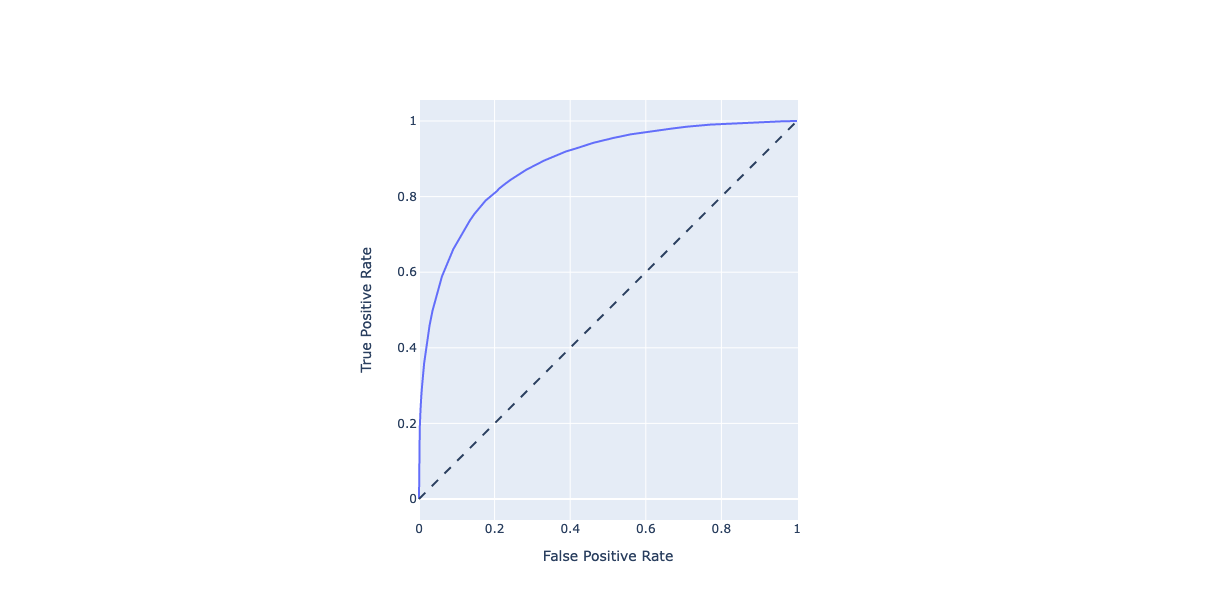

In [18]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fpr, tpr, thresholds = roc_curve(y_, pred_)
fig.add_trace(
    go.Scatter(x=fpr, y=tpr, mode='lines')
)
fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=600, height=600
)
fig.show()

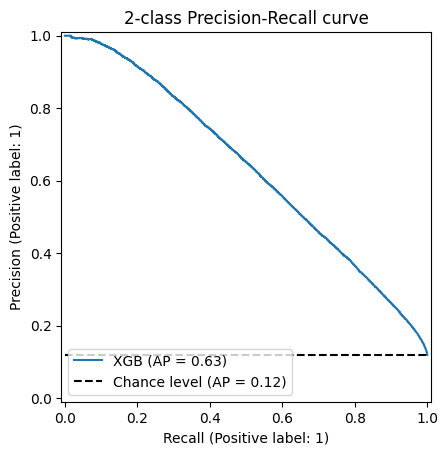

In [19]:
display = PrecisionRecallDisplay.from_predictions(
    y_, pred_, name='XGB', plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

In [ ]:
val_arr, _, _ = gbdt._to_xgboost_input(val_tf[:5000])
shap_values = explainer.shap_values(val_arr, pred_[:5000])

In [69]:
# TODO verify
feat_names = val_tf.col_names_dict[stype.categorical] + val_tf.col_names_dict[stype.numerical]

/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning:

All-NaN slice encountered



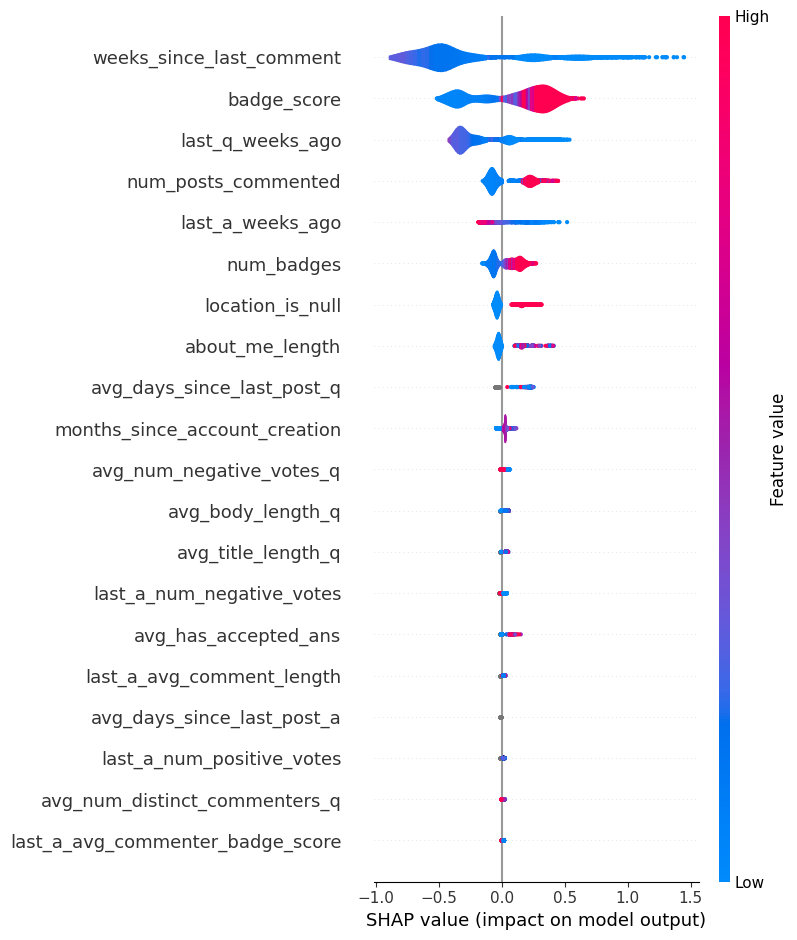

In [71]:
shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=20,
                  feature_names=feat_names)

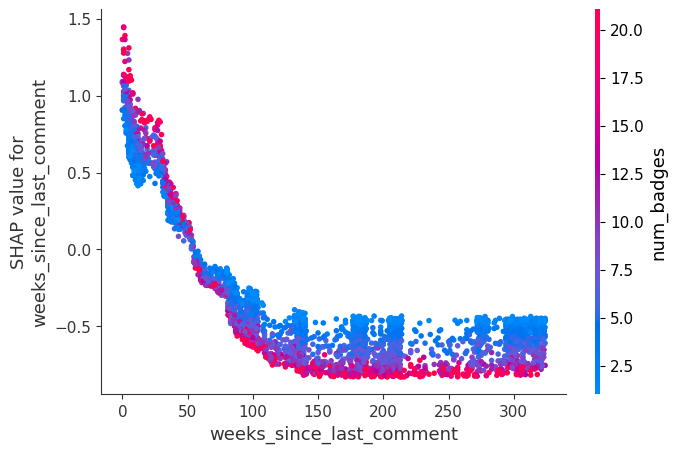

In [72]:
shap.dependence_plot('weeks_since_last_comment', shap_values, val_arr, feature_names=feat_names)

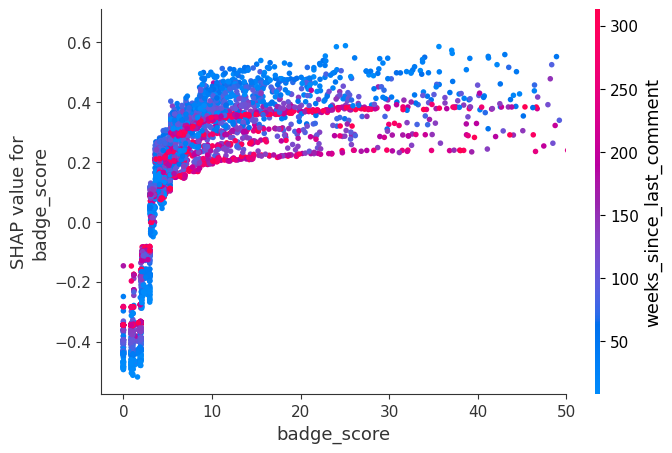

In [87]:
shap.dependence_plot('badge_score', shap_values, val_arr, feature_names=feat_names, xmin=0, xmax=50)

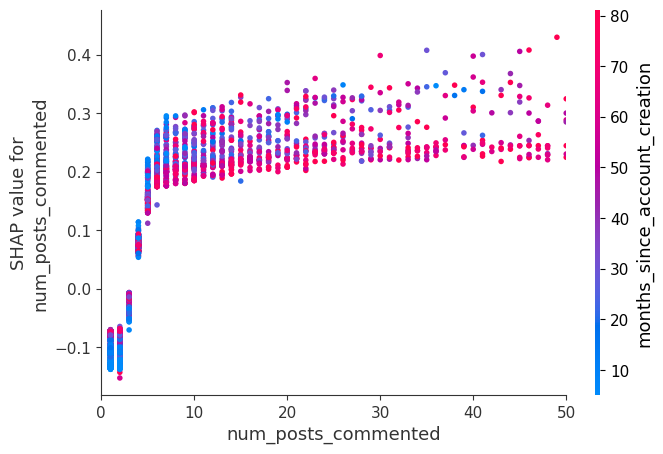

In [90]:
shap.dependence_plot('num_posts_commented', shap_values, val_arr, feature_names=feat_names,
                     interaction_index='months_since_account_creation', xmin=0, xmax=50)

### Test Eval

In [27]:
import numpy as np
from relbench.datasets import get_dataset

In [33]:
task = (
    get_dataset('rel-math-stackex', process=True, cache_dir='data/')
    .get_task('rel-stackex-engage', process=True)
)

making Database object from raw files...
Loading data from: /lfs/hyperion/0/adobles/relbench-user-study/stack_exchange/data/25a03b9a227fa6fadbd949a4ea4721f2-relbench-stackex-raw/math-stackex-temp


/lfs/hyperion/0/adobles/relbench/relbench/datasets/math_stackex.py:56: DtypeWarning:

Columns (0,1,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.

/lfs/hyperion/0/adobles/relbench/relbench/datasets/math_stackex.py:62: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Data loaded
Percentage of rows removed due to invalid dates: 4.21%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
done in 229.35 seconds.
reindexing pkeys and fkeys...
done in 36.43 seconds.


In [34]:
test_df = conn.sql('select * from engage_test_feats').df()
test_tf = train_dset.convert_to_tensor_frame(test_df.drop(DROP_COLS, axis=1))

In [35]:
pred = gbdt.predict(tf_test=test_tf)
preds = {uid: p for uid, p in zip(test_df.user_id, pred)}
pred = np.array([preds[uid] for uid in task.test_table.df.OwnerUserId])

In [36]:
task.evaluate(pred)

{'average_precision': 0.6163367477249041,
 'accuracy': 0.9284028557228013,
 'f1': 0.541677201854193,
 'roc_auc': 0.8941431229671846}

In [37]:
conn.close()